# $$
\text{Résolution de systèmes linéaires}
$$

### Objectifs :

- introduire des routines de numpy pour résoudre des systèmes linéaires ;
- explorer des méthodes directes (méthode du pivot de Gauss, décompositions LU, de Cholesky et PLU) pour cette résolution ;
- utiliser des méthodes itératives pour résoudre des systèmes linéaires (méthodes de Jacobi et de Gauss-Seidel) ou pour déterminer des valeurs propres (méthode de la puissance itérée).

## I. Routines proposées par numpy

Pour résoudre le système linéaire
$$
A x = b
$$
lorsque la matrice $A$ est inversible, il est possible d'écrire $x = A^{-1} b$, donc de faire appel à la fonction `linalg.inv` de numpy :

In [1]:
import numpy as np
A0=np.array([[10,1,2],[3,6,1],[0,2,7]])
b0=np.array([[1],[2],[3]])
x0=np.linalg.inv(A0)@b0    # calcule la matrice A0^{-1} puis l'applique au vecteur b0
print('x0 =',x0,'\n')
print(A0@np.reshape(x0,(3,1))-b0,'\n')

x0 = [[0.00255754]
 [0.27365729]
 [0.35038363]] 

[[ 0.0000000e+00]
 [-4.4408921e-16]
 [-4.4408921e-16]] 



Inverser la matrice $A$ puis calculer le vecteur $A^{-1} b$ peut être trop coûteux en temps. Sans parler du cas où cette matrice n'est pas inversible, mais où le système $A x = b$ admet des solutions.

Une routine rapide intégrée à numpy pour une résolution lorsque $A$ est inversible est donnée par la commande `np.linalg.solve(A,b)`. Cette routine utilise la décomposition $PLU$ décrite ci-dessous :

In [2]:
x1=np.linalg.solve(A0,b0) # calcule la solution x0 de A0 x0 = b0 sans inverser A0
print('x1 =',x1,'\n')

x1 = [[0.00255754]
 [0.27365729]
 [0.35038363]] 



## II. Résolution de systèmes linéaires par des méthodes directes

### 1. Méthode du pivot de Gauss

Dans le cas d'un système triangulaire inférieur dont les coefficients diagonaux sont non nuls,
$$
\begin{cases} l_{0,0} x_0 & & & & & & & = & b_0, \\
l_{1,0} x_0 & + & l_{1,1} x_1 & & & & & = & b_1, \\
\ldots & + & \ldots & + & \ldots & & & = & \ldots, \\
l_{n-1,0} x_0 & + & l_{n-1,1} x_1 & + & \ldots & + & l_{n-1,n-1} x_{n-1,n-1} & = & b_{n-1},
\end{cases}
$$
la recherche des solutions se réduit à calculer successivement $x_0$, puis $x_1$, et ce, jusqu'à $x_{n-1}$. En effet, la première ligne du système donne
$$
x_0 = \frac{b_0}{l_{0,0}}.
$$
Une fois cette valeur de $x_0$ connue, la deuxième ligne donne la valeur de
$$
x_1 = \frac{b_1 - l_{1,0}x_0}{l_{1,1}},
$$
puis, au début de l'étape $k$, $x_0$, $x_1$, ..., et $x_{k-1}$ sont connus, et la $k$-ième ligne du système donne alors
$$
x_k = \frac{b_k - l_{k,0} x_0 - \ldots - l_{k,k-1} x_{k-1}}{l_{k,k}}.
$$
Suivant cette approche dite de la remontée, la fonction `sol_tri_inf(L,b)` prend en entrée une matrice triangulaire inférieure $L=(l_{i,j})_{0 \leq i,j \leq n-1}$ et un vecteur $b = (b_0, \ldots, b_{n-1})$, et retourne la solution de $L x = b$. Le code utilise la fonction `np.sum(v)` qui renvoie la somme des éléments $v_0 + v_1 + \ldots + v_{m-1}$ d'un vecteur $v$ de taille $m$ :

In [3]:
def sol_tri_inf(L,b):
    n=len(b)                       # n est la dimension du vecteur b
    x=np.zeros(n)                  # création d'un vecteur x de longueur n
    for k in range(n):              # calcul itératif des valeurs x_k pour k=0, k=1, ...., jusqu'a k=n-1
        x[k]=(b[k]-np.sum(L[k,0:k]*x[0:k]))/L[k,k]    # L[k,0:k]*x[0:k] est le vecteur (l_{k,0}x_0,...,l_{k,k-1}x_{k-1})
    return x
# Test de la fonction sol_tri_inf(L,b)
L3=np.array([[1,0,0],[2,1,0],[1,2,3]])
b3=np.array([3,2,1])
x3=sol_tri_inf(L3,b3)
print('x3 =',x3,'\n')
print(L3@np.reshape(x3,(3,1))-np.reshape(b3,(3,1)),'\n')

x3 = [ 3. -4.  2.] 

[[0.]
 [0.]
 [0.]] 



L'approche est similaire pour résoudre un système triangulaire supérieur
$$
\begin{cases}
u_{0,0}x_0 & + & u_{0,1}x_1 & + & \ldots & + & u_{0,n-1}x_{n-1} & = & b_0, \\
u_{1,1}x_1 & + & \ldots & + & u_{1,n-1}x_{n-1} & & & = & b_1, \\
\ldots & + & \ldots & & & & & = & \ldots, \\
u_{n-1,n-1} x_{n-1,n-1} & & & & & & & = & b_{n-1},
\end{cases}
$$
lorsque les coefficients diagonaux $u_{0,0}$, ..., et $u_{n-1,n-1}$ sont non nuls : calcul de $x_{n-1}$, puis de $x_{n-2}$, et ce, jusqu'à $x_0$. C'est ce qu'implémente la fonction `sol_tri_sup(U,b)` :

In [4]:
def sol_tri_sup(U,b):
    n=len(b)               
    x=np.zeros(n)       
    for k in range(n): 
        x[n-1-k]=(b[n-1-k]-np.sum(U[n-1-k,n-k:n]*x[n-k:n]))/U[n-1-k,n-1-k]
    return x

Afin de résoudre le système linéaire
$$
\begin{cases}
a_{0,0} x_0 & + & a_{0,1} x_1 & + & \ldots & + & a_{0,n-1} x_{n-1} & = & b_0, \\
a_{1,0} x_0 & + & a_{1,1} x_1 & + & \ldots & + & a_{1,n-1} x_{n-1} & = & b_1, \\
\ldots & + & \ldots & + & \ldots & + & \ldots & = & \ldots, \\
a_{n-1,0} x_0 & + & a_{n-1,1} x_1 & + & \ldots & + & a_{n-1,n-1} x_{n-1} & = & b_{n-1},
\end{cases}
$$
la méthode du pivot de Gauss consiste à se ramener à un système triangulaire. Si le coefficient $a_{0,0}$ n'est pas nul, ajouter $- a_{1,0} / a_{0,0}$ fois la première ligne à la seconde ligne conduit au système
$$
\begin{cases}
a_{0,0} x_0 & + & a_{0,1} x_1 & + &\ldots & + & a_{0,n-1} x_{n-1} & = & b_0, \\
& & \big( a_{1,1} - \frac{a_{1,0}}{a_{0,0}} a_{0,1} \big) x_1 & + & \ldots & + & \big( a_{1,n-1} - \frac{a_{1,0}}{a_{0,0}} a_{0,n-1} \big) x_{n-1} & = & b_1 - \frac{a_{1,0}}{a_{0,0}} b_0, \\
\ldots & + & \ldots & + &\ldots & + & \ldots & = & \ldots, \\
a_{n-1,0} x_0 & + & a_{n-1,1} x_1 & + & \ldots & + & a_{n-1,n-1} x_{n-1} & = & b_{n-1},
\end{cases}
$$
où la présence de $x_0$ a disparu dans la deuxième ligne. De même, ajouter $- a_{2,0}/a_{0,0}$ fois la première ligne à la troisième efface la présence de $x_0$ dans cette ligne, et il suffit d'itérer pour toutes les lignes suivantes pour obtenir le système équivalent
$$
\begin{cases}
a_{0,0} x_0 & + & a_{0,1} x_1 & + & \ldots & + & a_{0,n-1} x_{n-1} & = & b_0, \\
& & \big( a_{1,1} - \frac{a_{1,0}}{a_{0,0}} a_{0,1} \big) x_1 & + & \ldots & + & \big( a_{1,n-1} - \frac{a_{1,0}}{a_{0,0}} a_{0,n-1}\big) x_{n-1} & = & b_1-\frac{a_{1,0}}{a_{0,0}} b_0, \\
& & \ldots & + & \ldots & + & \ldots & = & \ldots, \\
& & \big( a_{n-1,1} - \frac{a_{n-1,0}}{a_{0,0}} a_{0,1} \big) x_1 & + & \ldots & + & \big( a_{n-1,n-1} - \frac{a_{n-1,0}}{a_{0,0}} a_{0,n-1} \big) x_{n-1} & = & b_{n-1} - \frac{a_{n-1,0}}{a_{0,0}} b_0,
\end{cases}
$$
où $x_0$ n'apparaît plus que dans la première ligne.

Il s'agit alors d'opérer de façon similaire pour éliminer la présence de $x_1$ dans les lignes $2$ à $n$ du système, puis d'itérer ce processus pour chaque colonne. Le système initial est alors transformé en un système équivalent de la forme
$$
Ux = c,
$$ où $U$ est une matrice triangulaire supérieure. Ce système se résout ensuite à l'aide de l'algorithme de remontée pour les matrices trianguaires supérieures.

Notons que cet algorithme ne peut être effectué que si les coefficients rencontrés itérativement sur la diagonale sont tous non nuls : ce sont ces pivots qui permettent en effet d'éliminer la présence de la variable $x_k$ dans les lignes $k + 1$ jusqu'à $n - 1$. Basée sur cet algorithme du pivot de Gauss, la fonction suivante `transfo_tri_sup(A,b)` prend en entrée une matrice $A$ et un vecteur $b$, et retourne le couple $(U, c)$ associé au système triangulaire équivalent :

In [5]:
def transfo_tri_sup(A,b):
    n=len(b)
    U=np.copy(A)
    c=np.copy(b)
    for j in range(n):
        for i in range(j+1,n):
            c[i]=c[i]-(U[i,j]/U[j,j])*c[j]
            U[i,:]=U[i,:]-(U[i,j]/U[j,j])*U[j,:]
    return(U,c)

Le système $A(x) = b$ se résout alors en appliquant la fonction `sol_tri_sup` au système équivalent $Ux = c$ :

In [6]:
def sol_pivot(A,b):
    (U,c)=transfo_tri_sup(A,b)
    return sol_tri_sup(U,c)
# Test de la fonction sol_pivot
A4=np.array([[1.,1,1],[2,1,1,],[0,3,1]])
b4=np.array([1.,2,3])
x4=sol_pivot(A4,b4)
print('x =',x4,'\n')
print(A4@x4-b4)

x = [ 1.   1.5 -1.5] 

[0. 0. 0.]


Rappelons que la fonction `transfo_tri_sup` ne fonctionne que si les coefficients rencontrés itérativement sur la diagonale sont non nuls et peuvent servir de pivots. Il est en fait possible de permuter des lignes pour résoudre ce problème. Étudions le cas particulier où le premier coefficient du système est nul. Plus précisément, intéressons-nous au système $Ax = b$ avec une matrice $A$ de la forme
$$
A=\begin{pmatrix}
 0 & a_{0,1} & \ldots & a_{0,n-1} \\
 0 & a_{1,1} & \ldots & a_{1,n-1} \\
 \ldots & \ldots & \ldots & \ldots \\
 0 & a_{k-1,1} & \ldots & a_{k-1,n-1} \\
 a_{k,0} & a_{k,1} & \ldots & a_{k,n-1} \\
 a_{k+1,0} & a_{k+1,1} & \ldots & a_{k+1,n-1} \\
 \ldots & \ldots & \ldots & \ldots \\
 a_{n-1,0} & a_{n-1,1} & \ldots & a_{n-1,n-1} \\
\end{pmatrix}
$$
pour laquelle $a_{k,0} \neq 0$. La permutation de la première ligne du système $Ax = b$ avec la $k$-ième conduit au système équivalent
$$
\begin{pmatrix}
 a_{k,0} & a_{k,1} & \ldots & a_{k,n-1} \\
 0 & a_{1,1} & \ldots & a_{1,n-1} \\
 \ldots & \ldots & \ldots & \ldots \\
 0 & a_{k-1,1} & \ldots & a_{k-1,n-1} \\
  0 & a_{0,1} & \ldots & a_{0,n-1} \\
 a_{k+1,0} & a_{k+1,1} & \ldots & a_{k+1,n-1} \\
 \ldots & \ldots & \ldots & \ldots \\
 a_{n-1,0} & a_{n-1,1} & \ldots & a_{n-1,n-1} \\
\end{pmatrix} x = \begin{pmatrix} b_k \\ b_1 \\ \ldots \\ b_{k-1} \\ b_0 \\ b_{k+1} \\ \ldots \\ b_{n-1} \end{pmatrix}.
$$
Puisque le nombre $a_{k,0}$ n'est pas nul, il peut servir de pivot pour éliminer la variable $x_0$ de la seconde à la dernière ligne de ce nouveau système, et il suffit d'itérer cet argument pour mener à bien la méthode du pivot de Gauss (au moins dans le cas où la matrice $A$ est inversible). Ce principe conduit à la décomposition $PLU$ détaillée ci-dessous.

### 2. La décomposition $LU$

Supposons qu'une matrice $A$ puisse s'écrire sous la forme
$$
A = LU,
$$
où
$$
L=\begin{pmatrix}  1 & 0 & & (0) \\ l_{1,0} & 1 & 0 & \\ \ldots & \ldots & \ldots & 0 \\ l_{n-1,0} & l_{n-1,1} & \ldots & 1 \end{pmatrix} \quad \text{ et } \quad U = \begin{pmatrix} u_{0,0} & u_{0,1} &. & u_{0,n-1} \\ 0 & u_{1,1} & \ldots & \ldots \\  & 0 & \ldots & \ldots \\ (0) &  & 0 & u_{n-1,n-1} \end{pmatrix},
$$
sont une matrice triangulaire inférieure avec des $1$ sur la diagonale, et une matrice triangulaire supérieure dont les élements diagonaux sont non nuls. Alors le calcul explicite du coefficient en position $(i, j)$ du produit $L U$ conduit aux formules
$$
a_{i,j} = u_{i,j} + l_{i,i-1}u_{i-1,j} + \ldots + l_{i,0}u_{0,j},
$$
si $j\geq i$, et
$$
a_{i,j} = l_{i,j}u_{j,j} + l_{i,j-1}u_{j-1,j} + \ldots + l_{i,0}u_{0,j},
$$
lorsque $j<i$.

Ces identités permettent de calculer les matrices $L$ et $U$ lorsqu'elles existent : il s'agit de calculer d'abord la première ligne de $U$ et la première colonne de $L$, puis la deuxième ligne de $U$ et la deuxième colonne de $L$, et ainsi de suite. En effet, si les $k-1$-ièmes premières lignes de $U$ et les $k-1$-ièmes premières colonnes de $L$ sont connues, la $k$-ième ligne de $U$ se déduit de la formule
$$
\forall k \leq j \leq n-1, \, u_{k,j} = a_{k,j} - l_{k,k-1}u_{k-1,j} - \ldots - l_{k,0}u_{0,j},
$$
tandis que la $k$-ième colonne de $L$ s'obtient grâce à l'expression
$$
\forall k+1 \leq i \leq n-1, \, l_{i,k} = \frac{a_{i,k} - l_{i,k-1}u_{k-1,k} - \ldots - l_{i,0}u_{0,k}}{u_{k,k}}.
$$
Cet algorithme pour calculer la décomposition $LU$ d'une matrice $A$ (lorsque c'est possible) est implémenté par la fonction `decomp_LU` suivante :

In [7]:
def decomp_LU(A):
    n=len(A)
    L=np.identity(n)
    U=np.zeros(np.array([n,n]))
    for k in range(n):
        for j in range(k,n):
            U[k,j]=A[k,j]-np.sum(L[k,0:k]*U[0:k,j])
        for i in range(k,n):
            L[i,k]=(A[i,k]-np.sum(L[i,0:k]*U[0:k,k]))/U[k,k]
    return(L,U)
# Test de la fonction decomp_LU
A5=np.array([[1,1,0],[0,2,3],[1,5,5]])
print('A =',A5,'\n')
L5,U5=decomp_LU(A5)
print('L =',L5,'\n')
print('U =',U5,'\n')
print(A5-L5@U5)

A = [[1 1 0]
 [0 2 3]
 [1 5 5]] 

L = [[1. 0. 0.]
 [0. 1. 0.]
 [1. 2. 1.]] 

U = [[ 1.  1.  0.]
 [ 0.  2.  3.]
 [ 0.  0. -1.]] 

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Le système $Ax = b$ est maintenant équivalent à $LUx = b$. En posant $y = Ux$, nous pouvons d'abord calculer $y$ en résolvant $Ly = b$, puis calculer $x$ en résolvant $Ux = y$. Ces deux systèmes sont triangulaires, et peuvent être résolus rapidement par l'algorithme de la remontée. La fonction `sol_LU(A,b)` résout le système $Ax = b$ de cette manière :

In [8]:
def sol_LU(A,b):
    (L,U)=decomp_LU(A)
    y=sol_tri_inf(L,b)
    return sol_tri_sup(U,y)
# Test de la fonction sol_LU
A6=np.array([[1,10,2],[0,22,-1],[1,5,10]])
b6=np.array([1,1,2])
x6=sol_LU(A6,b6)
print('x =',x6,'\n')
print(A6@x6-b6)

x = [0.15789474 0.05263158 0.15789474] 

[0. 0. 0.]


### 3. La décomposition de Cholesky

Les matrices symétriques définies positives $M$ admettent une décomposition plus simple que la décomposition $LU$, appelée décomposition de Cholesky, qui s'écrit sous la forme $M = LL^T$, dans laquelle la matrice triangulaire inférieure $L$ possède des coefficients diagonaux strictement positifs. La fonction `linalg.cholesky(M)` de numpy donne la décomposition de Cholesky d'une matrice symmétrique définie positive :

In [9]:
M7=np.array([[10,1,-1],[1,8,0],[-1,0,12]])
L7=np.linalg.cholesky(M7)
print('M =',M7,'\n')
print('L =',L7,'\n')
print(M7-L7@np.transpose(L7))

M = [[10  1 -1]
 [ 1  8  0]
 [-1  0 12]] 

L = [[ 3.16227766  0.          0.        ]
 [ 0.31622777  2.81069386  0.        ]
 [-0.31622777  0.0355784   3.44945419]] 

[[-1.77635684e-15  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.91829157e-18]
 [ 0.00000000e+00  8.91829157e-18  0.00000000e+00]]


### 4. La décomposition $PLU$

Toute matrice $M$ n'admet pas nécessairement de décomposition $LU$, mais elle admet une décomposition  $M=PLU$ dans laquelle $P$ est une matrice de permutation, $L$ est une matrice triangulaire inférieure avec des $1$ sur la diagonale, et $U$ est une matrice triangulaire supérieure. Afin de déterminer cette nouvelle décomposition, définissons d'abord la fonction `permutation(n,i,k)`, qui étant donnés des entiers $i$, $k$, $n$ tels que $i \neq k$ et $i, k <n$, renvoie la matrice de permutation élémentaire qui permute le i-ième et le k-ième élément de la base canonique de $\mathbb{R}^n$ : 

In [10]:
def permutation(n,i,k):
    P=np.identity(n)
    P[i,i]=0
    P[k,k]=0
    P[i,k]=1
    P[k,i]=1
    return(P)
# Test de l'involutivité de la fonction permutation(n,i,k)
print(permutation(3,0,1)@permutation(3,0,1),'\n')

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 



La fonction `PLU(A)` ci-dessous renvoie la decomposition $PLU$ de la matrice $A$. Elle repose sur un code similaire à celui de la fonction `decomp_LU`, mais qui intégre maintenant le choix du pivot à l'aide des matrices de permutation :

In [11]:
def PLU(A):
    n=len(A)
    P=np.identity(n)
    L=np.identity(n)
    U=np.identity(n)
    U[:]=A
    for j in range(0,n-1):
        if U[j,j]!=0:
            for i in range(j+1,n):
                p=-U[i,j]/U[j,j]
                U[i,j:n]=U[i,j:n]+p*U[j,j:n]
                L[i,j]=-p
        else:
            k=j+1
            while k!=n and U[k,j]==0:
                k+=1
            if k!=n:
                U=permutation(n,j,k)@U
                L=permutation(n,j,k)@L@permutation(n,j,k)
                P=P@permutation(n,j,k)
                for i in range(j+1,n):
                    p=-U[i,j]/U[j,j]
                    U[i,j:n]=U[i,j:n]+p*U[j,j:n]
                    L[i,j]=-p
    return(P,L,U)
# Test de la fonction PLU()
A8=np.array([[1,1,0],[1,1,0],[1,2,1]])
P8,L8,U8=PLU(A8)
print('A =',A8,'\n')
print('P =',P8,'\n')
print('L =',L8,'\n')
print('U =',U8,'\n')
print(A8-P8@L8@U8)

A = [[1 1 0]
 [1 1 0]
 [1 2 1]] 

P = [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]] 

L = [[1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 1.]] 

U = [[1. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]] 

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## II. Méthodes itératives pour la résolution de systèmes linéaires et le calcul de valeurs propres

### 1. La méthode de Jacobi

Étant donnée une matrice $A$, la méthode de Jacobi consiste à introduire la décomposition $A = D - E -F$, dans laquelle $D$ est la diagonale de $A$, $- E$ représente la partie sous-diagonale de $A$, et $- F$ la partie sur-diagonale. Si $D$ est inversible, résoudre le système $A x = b$ équivaut à résoudre :
$$
x = D^{-1} \big( E + F \big) x + y,
$$
où $y = D^{- 1} b$. La fonction `DEF(A)` ci-dessous renvoie le triplet $(D, E ,F)$ associée à la méthode de Jacobi. Elle est basée sur la commande `numpy.diag` qui permet aussi bien d'extraire la diagonale d'une matrice que de créer une matrice diagonale :

In [12]:
def DEF(A):
    D=np.diag(np.diag(A))
    n=len(A)
    E=np.zeros((n,n))
    F=np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            E[i,j]=-A[i,j]
    for j in range(1,n):
        for i in range(0,j):
            F[i,j]=-A[i,j]
    return(D,E,F)
# Test de la fonction DEF
A=np.array([[1,2],[3,4]])
print('A =',A,'\n')
D=DEF(A)[0]
E=DEF(A)[1]
F=DEF(A)[2]
print('D =',D,'\n')
print('E =',E,'\n')
print('F =',F,'\n')

A = [[1 2]
 [3 4]] 

D = [[1 0]
 [0 4]] 

E = [[ 0.  0.]
 [-3.  0.]] 

F = [[ 0. -2.]
 [ 0.  0.]] 



La méthode de Jacobi consiste alors à appliquer une méthode de point fixe pour déterminer la solution $x$. Dans la cas où l'application $x \mapsto D^{- 1} (E + F) x + y$ est contractante (ce qui est équivalent au fait que le rayon spectral de $D^{-1} (E + F)$ est strictement inférieur à $1$), le théorème du point fixe de Banach assure que
- si $x_0 \in \mathbb{R}^n$ est choisi de façon quelconque,
- et si nous calculons $x_1 = D^{- 1}(E + F) x_0 + y$, puis les itérés successifs par la formule $x_k = D^{-1}(E + F) x_{k-1} + y$,

alors la suite $(x_k)_{k \geq 0}$ converge vers l'unique solution $x$ de l'équation. En particulier, l'erreur résiduelle $|Ax_{k}-b|$ tend vers $0$. Il est donc possible de choisir un seuil d'erreur $\varepsilon > 0$ et d'arrêter le calcul des itérés successifs lorsque l'erreur résiduelle rapportée à la taille du vecteur à inverser est plus petite que le seuil :
$$
\frac{|Ax_k - b|}{|b|}< \epsilon.
$$
La fonction suivante `Jacobi(A,b,e)` code cet algorithme pour trouver une solution approchée avec cette estimation du résidu. Le calcul de la norme euclidienne se fait à l'aide de la commande `numpy.linalg.norm` qui permet de calculer de nombreuses normes vectorielles (et par défaut, la norme euclidienne).

In [13]:
def Jacobi(A,b,e):
    n=len(b)
    normb=np.linalg.norm(b)
    x=np.reshape(np.zeros(n),(n,1))
    r=2*e
    (D,E,F)=DEF(A)
    Dinv=np.diag(np.ones(n)/np.diag(A))
    y=Dinv@b
    while r>e:
        x=Dinv@((E+F)@ x)+y
        r=np.linalg.norm(A@x-b)/normb
    return(x,r)
# Test de la méthode de Jacobi
A=np.array([[10 , 1 , 2 ,4],[ -5 , 9 ,0 ,2],[ 1 ,-2 ,6, 1],[ -1 , -3 , 0 ,8]])
print('A =',A,'\n')
b=np.array([[1],[2],[3],[4]])
print('b =',b,'\n')
x=Jacobi(A,b,0.0001)[0]
print('x =',x,'\n')
print(A@np.reshape(x,(4,1))-b,'\n')

A = [[10  1  2  4]
 [-5  9  0  2]
 [ 1 -2  6  1]
 [-1 -3  0  8]] 

b = [[1]
 [2]
 [3]
 [4]] 

x = [[-0.18480248]
 [ 0.01255567]
 [ 0.45471116]
 [ 0.48159242]] 

[[ 3.22901332e-04]
 [ 1.98284101e-04]
 [-5.44677075e-05]
 [-1.25176396e-04]] 



### 2. La méthode de Gauss-Seidel

La méthode de Gauss-Seidel repose sur la décomposition $A = L-F$, où $L$ est triangulaire inférieure et $F$ est triangulaire supérieure à diagonale nulle. Résoudre le système linéaire
$$
A x = b,
$$
est donc équivalent à résoudre
$$
L x = F x + b.
$$
La méthode de Gauss-Seidel consiste donc :
- à choisir un vecteur initial $x_0 \in \mathbb{R}^n$,
- puis à calculer la solution $x_1$ de $L x_1 = F x_0 + b$.

**Attention !** Puisque $L$ est triangulaire inférieure, il n'est par utile de l'inverser pour trouver $x_1$ : il suffit d'appliquer la méthode de remontée.

Puis les itérés successifs $x_2$, $x_3$, ... sont déterminés en résolvant de façon similaire $L x_k = F x_{k-1} + b$. Si $A$ est par exemple symmétrique définie positive, ou bien à diagonale dominante, la suite $(x_k)_{k \geq 0}$ converge vers l'unique solution $x$ du système initial.

Étant donné un seuil d'erreur $\varepsilon > 0$, le but est alors d'arrêter les itérations lorsque le résidu $|A x_k - b|/|b|$ est inférieur à $\varepsilon$. La fonction `gaussseidel(A,b,e)` rend compte de l'algorithme de Gauss-Seidel pour trouver une solution approchée de $A x = b$ avec une telle estimation du résidu :

In [14]:
def gaussseidel(A,b,e):
    n=len(b)
    normb=np.linalg.norm(b)
    (D,E,F)=DEF(A)
    L=D-E
    r=2*e
    x=np.zeros(n)
    while r>e:
        x=sol_tri_inf(L,F@x+b)
        r=np.linalg.norm(A@x-b)/normb
    return(x,r)
# Test de la méthode de Gauss-Seidel
A=np.array([[10 , 1 , 2 ,3],[ 1 , 9 ,4 ,2],[ 2 ,4 ,11, 0],[ 3 , 2 , 0 ,8]])
b=np.array([1,1,1,1])
u=gaussseidel(A,b,0.0000001)
print('A =',A,'\n')
print('b =',b,'\n')
print('u =',u,'\n')
print(A@np.reshape(u[0],(4,1)) - np.reshape(b, (4,1)),'\n')

A = [[10  1  2  3]
 [ 1  9  4  2]
 [ 2  4 11  0]
 [ 3  2  0  8]] 

b = [1 1 1 1] 

u = (array([0.05535477, 0.05858856, 0.05953966, 0.08959482]), 3.6149983226038895e-08) 

[[2.79607650e-08]
 [6.66744386e-08]
 [0.00000000e+00]
 [0.00000000e+00]] 



### 3. La méthode de la puissance itérée

Cette méthode cherche à déterminer le vecteur propre d'une matrice associé à la valeur propre de plus grand module, dans le cas où celle-ci est unique. Étant donnée une matrice $A \in \mathcal{M}_n(\mathbb{R})$ et un vecteur $\boldsymbol{x}_0 \in \mathbb{R}^n$, l'algorithme de la puissance itérée repose sur la suite de vecteurs $(\boldsymbol{x}_k)_ {k \geq 0}$ définie par
$$
\boldsymbol{x}_{k+1} = \frac{A \boldsymbol{x}_k}{|A \boldsymbol{x}_k|}.
$$
Lorsque la matrice $A$ est diagonalisable, il est possible de montrer qu'étant donné un vecteur $x_0$ générique, cette suite converge (à un signe près) vers un vecteur propre unitaire associé à la plus grande valeur propre $\lambda_1$ (en module) de la matrice $A$. Plus précisément, la suite $(x_k)_{k \geq 0}$ est convergente si $\text{signe}(\lambda_1) = + 1$, et la suite $((-1)^k x_k)_{k \geq 0}$ est convergente si $\text{signe}(\lambda_1) = - 1$. Dans les deux cas, le vecteur limite $v$ est unitaire et satisfait
$$
A v = \lambda_1 v.
$$

Cette affirmation repose sur la formule
$$
\boldsymbol{x}_k = \frac{A^k \boldsymbol{x}_0}{|A^k \boldsymbol{x}_0|}.
$$
Étant donnée que la matrice $A$ est diagonalisable, nous pouvons en effet introduire une base de vecteurs propres unitaires $(\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_n)$ associés aux valeurs propres $\lambda_1, \lambda_2, \ldots, \lambda_n$, où nous pouvons supposer que $\lambda_1$ est la valeur propre de plus grand module (ce qui implique qu'elle est réelle). Lorsque le vecteur $\boldsymbol{x}_0$ s'écrit sous la forme
$$
\boldsymbol{x}_0 = \sum_{i=1}^n c_i \boldsymbol{v}_i,
$$
nous obtenons
$$
A^k \boldsymbol{x}_0 = \lambda_1^k \Big( c_1 \boldsymbol{v}_1 + \sum_{i=2}^n c_i \big( \frac{\lambda_i}{\lambda_1} \big)^k \boldsymbol{v}_i \Big).
$$
Lorsque le coefficient $c_1$ n'est pas nul, nous déduisons de cette formule et du fait que $\boldsymbol{v}_1$ est unitaire que
$$
|A^k x_0| \sim |\lambda_1|^k|c_1|, \quad \text{ lorsque } k \to + \infty,
$$
puis que
$$
x_k \sim \frac{\lambda_1^k}{|\lambda_1^k|} \frac{c_1}{|c_1|} \boldsymbol{v}_1, \quad \text{ lorsque } k \to + \infty.
$$
Suivant le signe de $\lambda_1$, nous obtenons bien la convergence des suites $(x_k)_{k \geq 0}$ ou $((-1)^k x_k)_{k \geq 0}$ vers un vecteur propre unitaire de la matrice $A$.

En pratique, il suffit de choisir le vecteur initial $\boldsymbol{x}_0$ aléatoirement pour qu'il vérifie presque sûrement la condition $c_1\neq0$, et que la suite $(\boldsymbol{x}_{2 k})_ {k\in\mathbb{N}}$ converge vers un vecteur propre normalisé associé à la valeur propre de plus grand module de la matrice $A$. Étant donné un seuil d'erreur $\varepsilon > 0$, le but est alors d'arrêter les itérations lorsque l'erreur
$$
e_k = \big| x_{2 k} - x_{2k-2} \big|,
$$
est inférieure à $\varepsilon$.

## Exercices

### Exercice 1.

Résoudre
$$
\begin{cases}
17 x + b y - 15 z + 3 t = 5, \\
a x - 12 y + 8 z + t = - 3, \\
4 x + 11 y + c z - 5 t = 4, \\
3 x + 2 y + 4 z + 2 t = 1,
\end{cases}
$$
où $a$ est votre jour de naissance, $b$ votre mois de naissance, et $c$ le chiffre des unités de votre année de naissance.

In [15]:
A=np.array([[17,8,-15,3],[17,-12,8,1],[4,11,7,-5],[3,2,4,2]])
b=np.array([[5],[-3],[4],[1]])
X=np.linalg.solve(A,b)
print('X =',X,'\n')
print(A@x-b)

X = [[ 0.09151139]
 [ 0.36687371]
 [-0.02484472]
 [ 0.04554865]] 

[[-13.41708679]
 [  3.82697148]
 [ -3.82608151]
 [  1.25273338]]


### Exercice 2.

1. Utiliser la commande `numpy.linalg.eig` pour calculer les valeurs propres et les vecteurs propres de la matrice
$$
M = \begin{pmatrix} 1 & 2 \\ 3 & 4 \end{pmatrix}.
$$

In [16]:
M=np.array([[1,2],[3,4]])
Val,P=np.linalg.eig(M)
print('Valeurs propres de M =',Val,'\n')
print('Vecteurs propres de M =',P,'\n')

Valeurs propres de M = [-0.37228132  5.37228132] 

Vecteurs propres de M = [[-0.82456484 -0.41597356]
 [ 0.56576746 -0.90937671]] 



2. Utilisez `np.linalg.eig` pour diagonaliser la matrice $M$, soit pour calculer une matrice de changement de base $P$ et une matrice diagonale $D$ telle que $M = P D P^{-1}$.

In [17]:
print('P =',P,'\n')
D=np.diag(Val)
print('D=',D,'\n')
print(M-P@D@np.linalg.inv(P))

P = [[-0.82456484 -0.41597356]
 [ 0.56576746 -0.90937671]] 

D= [[-0.37228132  0.        ]
 [ 0.          5.37228132]] 

[[5.55111512e-16 4.44089210e-16]
 [4.44089210e-16 4.44089210e-16]]


### Exercice 3.

Dans l'algorithme de la fonction `sol_tri_inf`, le calcul de $x[k]$ nécessite $k$ multiplications, $k$ additions et une division, soit un total de $2 k + 1$ opérations. Le nombre total d'opérations effectuées par l'algorithme est donc
$$
\sum_{k=0}^{n-1} \big( 2 k + 1 \big) = n^2,
$$
ce qui est noté $O(n^2)$. Cet équivalent du nombre d'opérations effectuées par un algorithme est appelée sa complexité.

1. Pouvez-vous estimer la complexité de l'algorithme de la fonction `transfo_tri_sup` ?

La fonction `transfo_tri_sup` comporte $n$ itérations pour $0 \leq j \leq n - 1$ qui comportent chacune d'entre elles $n - j - 1$ itérations pour $j + 1 \leq i \leq n - 1$. Chacune des itérations en $i$ nécessitent $3 n + 3$ opérations, de sorte que le nombre total d'opérations effectuées est égal à :
$$
\sum_{j = 0}^{n - 1} \sum_{i = j + 1}^{n - 1} (3 n + 3) = (3 n + 3) \sum_{j = 0}^{n - 1} (n - j - 1) = \frac{3}{2} (n - 1) n (n + 1).
$$
La complexité de cette fonction est donc de l'ordre de $O(n^3)$.

2. Pouvez-vous estimer la complexité de l'algorithme de la fonction `decomp_LU` ?

La fonction `decomp_LU`comporte $n$ itérations pour $0 \leq k \leq n - 1$ qui comportent chacune d'entre elles $n - k$ itérations pour $k \leq j \leq n - 1$, ainsi que pour $k \leq i \leq n -1$. Chacune des itérations en $j$ requiert $2 k + 1$ opérations, tandis que celles en $i$ nécessitent $2 k + 2$ opérations. Par conséquent, le nombre total d'opérations effectuées est égal à :
$$
\sum_{k = 0}^{n - 1} \big( \sum_{j = k}^{n - 1} (2 k + 1) + \sum_{i = k}^{n - 1} (2 k + 2) \big) = \sum_{k = 0}^{n - 1} (n - k)(4 k + 3) = \frac{1}{6} (4 n - 5) n (n - 1) + 3 n^2.
$$
La complexité de cette fonction est donc de l'ordre de $O(n^3)$.

3. En déduire qu'appliquer la méthode du pivot, ou bien calculer la décomposition $LU$ de la matrice, puis appliquer la méthode de la remontée pour des systèmes triangulaires (en utilisant la fonction `sol_LU`) sont deux approches équivalentes en terme de complexité.

Sachant que la complexité de la fonction `sol_tri_inf` est de l'ordre de $O(n^2)$, calculer la décomposition $LU$, puis appliquer la méthode de la remontée pour des systèmes triangulaires conduit à une complexité de l'ordre de $O(n^3)$. De façon similaire, la méthode du pivot repose sur la fonction `transfo_tri_sup` et la méthode de la remontée pour des systèmes triangulaires, pour une complexité totale de l'ordre de $O(n^3)$. Ces deux approches sont donc équivalentes en terme de complexité.

### Exercice 4.

À l'aide de la fonction `decomp_LU(A)` qui donne la décomposition $LU$ d'une matrice, écrire une fonction $\text {det}$ qui calcule le déterminant de cette matrice.

In [18]:
def det(A):
    d=1
    L,U=decomp_LU(A)
    n,m=np.shape(A)
    for i in range(0,n):
        d=d*U[i,i]
    return d
# Test de la fonction det
A=np.array([[1,1,0],[0,2,3],[1,5,5]])
print('A =',A,'\n')
d=det(A)
print('det(A) =',d,'\n')

A = [[1 1 0]
 [0 2 3]
 [1 5 5]] 

det(A) = -2.0 



### Exercice 5.

Reprendre la méthode du pivot de Gauss implémentée dans `transfo_tri_sup` pour élaborer un algorithme `transfo_tri_sup2(A,b)` qui, quelle que soit la matrice inversible $A$, renvoie une matrice triangulaire supérieure $U$ et un vecteur $c$ tels que les systèmes $A x = b$ et $U x = c$ soient équivalents.

In [19]:
def transfo_tri_sup2(A,b):
    n=len(b)
    U=np.copy(A)
    c=np.copy(b)
    for j in range(n):
        l=j
        while U[l,j]==0.:
            l=l+1
        if l!=j:
            L=U[l,:]
            d=c[l]
            U[l,:]=U[j,:]
            c[l]=c[j]
            U[j,:]=L
            c[j]=d
        for i in range(j+1,n):
            l=c[i]-(U[i,j]/U[j,j])*c[j]
            c[i]=c[i]-(U[i,j]/U[j,j])*c[j]
            U[i,:]=U[i,:]-(U[i,j]/U[j,j])*U[j,:]
    return U,c
# Test de la fonction transfo_tri_sup2
A=np.array([[2.,1,2,1],[0,1,3,2],[1,2,-1,0],[1,-1,0,2]])
b=np.array([[1.],[1],[1],[1]])
U,c=transfo_tri_sup2(A,b)
print('U =',U,'\n')
print('c =',c,'\n')
print('x =',np.linalg.solve(A,b),'\n')
print('x =',np.linalg.solve(U,c),'\n')

U = [[ 2.          1.          2.          1.        ]
 [ 0.          1.          3.          2.        ]
 [ 0.          0.         -6.5        -3.5       ]
 [ 0.          0.          0.          2.61538462]] 

c = [[ 1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.46153846]] 

x = [[ 0.20588235]
 [ 0.32352941]
 [-0.14705882]
 [ 0.55882353]] 

x = [[ 0.20588235]
 [ 0.32352941]
 [-0.14705882]
 [ 0.55882353]] 



### Exercice 6.

Une fois la décomposition de Cholesky $M = L L^T$ connue, il est permis de résoudre le système $Mx = b$ en résolvant d'abord le système triangulaire inférieur $Ly = b$, puis le système triangulaire supérieur $L^T x = y$. À l'aide des fonctions `sol_tri_inf` et `sol_tri_sup`, implémenter une fonction `sol_chol(M,b)` qui prend en entrée une matrice symétrique définie positive $M$, et résout le système $Mx = b$ de cette manière. 

In [20]:
def sol_chol(M,b):
    L=np.linalg.cholesky(M)
    y=sol_tri_inf(L,b)
    return sol_tri_sup(np.transpose(L),y)
# Test de la fonction transfo_tri_sup2
M=np.array([[3,1,2,1],[1,4,0,2],[2,0,2,0],[1,2,0,2]])
b=np.array([1,1,1,1])
x=sol_chol(M,b)
print('x =',x,'\n')
print(M@x-b,'\n')

x = [-1.   0.   1.5  1. ] 

[-8.8817842e-16  0.0000000e+00  0.0000000e+00  0.0000000e+00] 



### Exercice 7.

La complexité de la fonction `PLU(A)` peut être améliorée : les opérations $U = permutation(n,j,k) @ U$, $L = permutation(n,j,k) @ L @ permutation(n,j,k)$ et $P = P @ permutation(n,j,k)$ mettent en jeu des multiplications de matrices de complexité d'ordre $O(n^2)$, alors que la multiplication à gauche par $permutation(n,j,k)$ revient à inverser les lignes $j$ et $k$ d'une matrice, et la multiplication à droite par $permutation(n,j,k)$, à inverser les colonnes $j$ et $k$. Modifier la fonction `PLU(A)` en une fonction `PLU2(A)` qui prenne en compte cette observation et effectue ces étapes en $O(n)$ opérations.

In [21]:
def PLU2(A):
    n=len(A)
    P=np.identity(n)
    L=np.identity(n)
    U=np.identity(n)
    U[:]=A
    for j in range(0,n-1):
        if U[j,j]!=0:
            for i in range(j+1,n):
                p=-U[i,j]/U[j,j]
                U[i,j:n]=U[i,j:n]+p*U[j,j:n]
                L[i,j]=-p
        else:
            k=j+1
            while k!=n and U[k,j]==0:
                k+=1
            if k!=n:
                ligne=np.copy(U[j,:])
                U[j,:]=U[k,:]
                U[k,:]=ligne
                ligne=np.copy(L[j,:])
                L[j,:]=L[k,:]
                L[k,:]=ligne
                colonne=np.copy(L[:,j])
                L[:,j]=L[:,k]
                L[:,k]=colonne
                colonne=np.copy(P[:,j])
                P[:,j]=P[:,k]
                P[:,k]=colonne
                for i in range(j+1,n):
                    p=-U[i,j]/U[j,j]
                    U[i,j:n]=U[i,j:n]+p*U[j,j:n]
                    L[i,j]=-p
    return(P,L,U)
# Test de la fonction PLU2()
A=np.array([[1,1,0],[1,1,0],[1,2,1]])
P,L,U=PLU2(A)
print('A =',A,'\n')
print('P =',P,'\n')
print('L =',L,'\n')
print('U =',U,'\n')
print(A-P@L@U)

A = [[1 1 0]
 [1 1 0]
 [1 2 1]] 

P = [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]] 

L = [[1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 1.]] 

U = [[1. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]] 

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### Exercice 8. 

Soit $a \in \mathbb{R}^*$. Nous cherchons à déterminer la convergence de la méthode de Jacobi pour les matrices
$$
A = A[a] = \begin{pmatrix} 1 & a & a \\ a & 1 & a \\ a & a & 1 \end{pmatrix}.
$$

1.a. Montrer que les valeurs propres de $A$ sont $1 + 2 a$ et $1 - a$, et donner un vecteur propre $e_1$ associé à $1 + 2 a$, et deux vecteurs propres non colinéaires $e_2$ et $e_3$ associés à $1 - a$.

Considérons la matrice
$$
B = \begin{pmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{pmatrix},
$$
et observons qu'elle satisfait
$$
\forall  a \in \mathbb{R}, \, A[a] = (1 - a) I_N + a B.
$$
En particulier, l'équation aux valeurs propres $A[a] X = \lambda X$ équivaut à l'équation
$$
a B X = (\lambda - 1 + a) X.
$$
Comme $a \neq 0$, nous concluons que $\lambda$ est une valeur de propre de la matrice $A[a]$ si et seulement si $(\lambda - 1 + a)/a$ est une valeur propre de la matrice $B$. De plus, les vecteurs propres des matrices $A[a]$ et $B$ pour ces valeurs propres sont égaux.

Comme la matrice $B$ est de rang $1$, nous savons que $0$ est une valeur propre de multiplicité $2$ de cette matrice, et nous observons que les vecteurs
$$
e_2 = \begin{pmatrix} 1 \\ -1 \\ 0 \end{pmatrix} \quad \text{ et } e_3 = \begin{pmatrix} 0 \\ 1 \\ - 1 \end{pmatrix},
$$
forment une base de vecteurs propres associés à cette valeur propre. Sachant que la trace de $B$ est égale à $3$, l'autre valeur propre est égale à $3$ et un vecteur propre associé est $$
e_1 = \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}.
$$
Pour $a \neq 0$, la matrice $A[a]$ possède donc deux valeurs propres $\lambda$ qui satisfont
$$
\lambda - 1 + a = 0 \quad \text{ ou } \quad \lambda - 1 + a = 3 a,
$$
et sont ainsi égales à $1 - a$ et $1 + 2 a$. De plus, $e_1$ est un vecteur propre associé à $1 + 2 a$, tandis que $e_2$ et $e_3$ sont deux vecteurs propres non colinéaires associés à $1 - a$.

b. Vérifier vos calculs numériquement à l'aide de la commande `numpy.linalg.eig`.

In [22]:
def MatA(a):
    return np.array([[1,a,a],[a,1,a],[a,a,1]])
print('Spectre de A[1] =',np.linalg.eig(MatA(1))[0],'\n')
print('Vecteurs propres de A[1] =',np.linalg.eig(MatA(1))[1],'\n')
print('Spectre de A[2] =',np.linalg.eig(MatA(2))[0],'\n')
print('Vecteurs propres de A[2] =',np.linalg.eig(MatA(2))[1],'\n')

Spectre de A[1] = [ 3.00000000e+00  6.16297582e-33 -7.50963641e-17] 

Vecteurs propres de A[1] = [[ 5.77350269e-01 -6.51147040e-17  6.09781659e-01]
 [ 5.77350269e-01 -7.07106781e-01 -7.75129861e-01]
 [ 5.77350269e-01  7.07106781e-01  1.65348202e-01]] 

Spectre de A[2] = [-1.  5. -1.] 

Vecteurs propres de A[2] = [[-0.81649658  0.57735027  0.03478434]
 [ 0.40824829  0.57735027 -0.72385699]
 [ 0.40824829  0.57735027  0.68907264]] 



2. Observons que la matrice $A$ se décompose sous la forme $ A = D-E-F$, avec
$$
D= Id, \quad E = \begin{pmatrix} 0 & 0 & 0 \\-a & 0 & 0 \\-a & -a & 0\end{pmatrix}, \quad \text{ et } \quad F = \begin{pmatrix} 0 & -a & -a \\ 0 & 0 & -a\\ 0 & 0 & 0 \end{pmatrix}.
$$
La suite des itérés de l'algorithme de Jacobi est donc donnée par la relation de récurrence
$$
x^{(k+1)} = \big( E + F \big) x^{(k)} + b,
$$
qui conduit à la formule
$$
x^{(k)} = \big( E + F \big)^k x^{(0)} + \sum_{i=0}^{k-1} \big( E + F \big)^i b.
$$

a. Décomposons les vecteurs $b = b_1 e_1 + b_2 e_2 + b_3 e_3$ et $x^{(k)}= x^{(k)}_1 e_1 + x^{(k)}_2 e_2 + x^{(k)}_3 e_3$ dans la base $\{e_1, e_2, e_3\}$ de la question 1. Vérifier alors que
$$
x^{(k)}_1 = (-2a)^k x^{(0)}_1 + \frac{1 - (-2a)^k}{1 + 2a} b_1, \quad x^{(k)}_2 = a^k x^{(0)}_2 + \frac{1 - a^k}{1 -a} b_2, \quad \text{ et } \quad x^{(k)}_3 = a^k x^{(0)}_3 + \frac{1-a^k}{1-a} b_3,
$$
lorsque $a \neq 1$ et $a \neq - 1/2$.

Nous vérifions que
$$
E + F = a Id - a B.
$$
Sachant que
$$
B e_1 = 3 e_1, \quad \text{ et } \quad B e_2 = B e_3 =0,
$$
nous obtenons
$$
(E + F) e_1 = (- 2 a) e_1, \quad (E + F) e_2 = a e_2, \quad \text{ et } \quad (E + F) e_3 = a e_3,
$$
puis par récurrence sur $k \geq 1$,
$$
(E + F)^k e_1 = (- 2 a)^k e_1, \quad (E + F) e_2 = a^k e_2, \quad \text{ et } \quad (E + F) e_3 = a^k e_3.
$$
Nous déduisons alors de la formule
$$
x^{(k)} = \big( E + F \big)^k x^{(0)} + \sum_{i=0}^{k-1} \big( E + F \big)^i b,
$$
que
$$
x^{(k)}_1 = (- 2 a)^k x_1^{(0)} + \sum_{i=0}^{k-1} (- 2 a)^i b_1.
$$
Comme $a \neq - 1/2$, nous savons que
$$
\sum_{i=0}^{k-1} (- 2 a)^i = \frac{1 - (-2a)^k}{1 + 2a},
$$
et nous concluons que
$$
x^{(k)}_1 = (-2a)^k x^{(0)}_1 + \frac{1 - (-2a)^k}{1 + 2a} b_1.
$$
De même, nous avons
$$
x^{(k)}_2 = a^k x^{(0)}_2 + \sum_{i=0}^{k-1} a^i b_2, \quad \text{ et } \quad x^{(k)}_3 = a^k x^{(0)}_3 + \sum_{i=0}^{k-1} a^i b_3.
$$
Sachant que $a \neq 1$, nous calculons
$$
\sum_{i=0}^{k-1} a^i = \frac{1 - a^k}{1 - a},
$$
et nous concluons que
$$
x^{(k)}_2 = a^k x^{(0)}_2 + \frac{1 - a^k}{1 - a} b_2, \quad \text{ et } \quad x^{(k)}_3 = a^k x^{(0)}_3 + \frac{1 - a^k}{1 - a} b_3.
$$

b. Supposons que $|a| > 1/2$ et que $x_1^{(0)} - b_1/(1+2a) \neq 0$. En déduire que
$$
\lim_{k \to + \infty} \| x^{(k)} \| = + \infty.
$$

Lorsque $|- 2 a| > 1$, nous déduisons des formules précédentes que
$$
x^{(k)}_1 \underset{k \to + \infty}{\sim} (-2a)^k \big( x^{(0)}_1 - \frac{b_1}{1 + 2a} \big).
$$
Quand $x_1^{(0)} - b_1/(1+2a) \neq 0$, cet équivalent suffit à conclure que
$$
|x^{(k)}_1| \underset{k \to + \infty}{\to} + \infty,
$$
puis que
$$
\| x^{(k)} \| \underset{k \to + \infty}{\to} + \infty.
$$

c. Supposons que $|a| <1/2$. La suite $(x^{(k)})_{k \geq 0}$ est-elle convergente ? Si oui, quelle est sa limite ?

Lorsque $|a| < 1/2$, nous savons que
$$
(- 2 a)^k \underset{k \to + \infty}{\to} 0, \quad \text{ et } \quad a^k \underset{k \to + \infty}{\to} 0,
$$
de sorte que
$$
x^{(k)}_1 \underset{k \to + \infty}{\to} \frac{b_1}{1 + 2a}, \quad x^{(k)}_2 \underset{k \to + \infty}{\to} \frac{b_2}{1 - a}, \quad \text{ et } \quad x^{(k)}_3 \underset{k \to + \infty}{\to} \frac{b_3}{1 - a}.
$$
La suite $(x^{(k)})_{k \geq 0}$ est donc convergente de limite $(b_1/(1 + 2 a), b_2/(1 - a), b_3/(1 - a))$.

3. Vérifier numériquement les résultats de la question 2. en représentant graphiquement les premiers termes de la suite $(x^{(k)})_{k \geq 0}$.

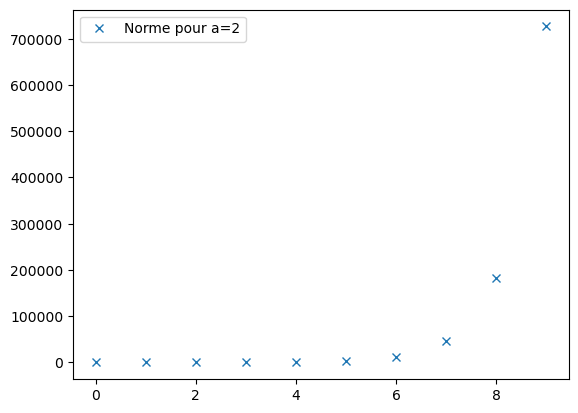

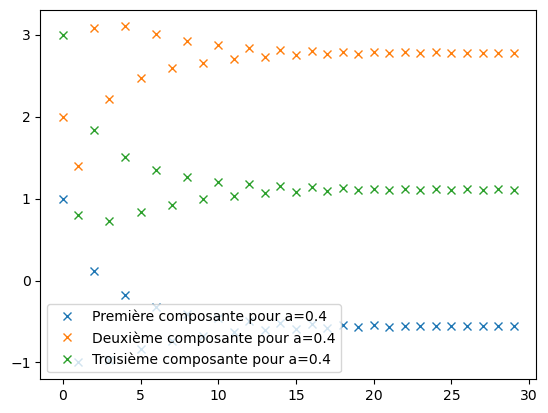

In [23]:
import matplotlib.pyplot as plt
def TermJaco(a,x0,b,N):
    M=np.eye(3)-MatA(a)
    x=np.copy(x0)
    L=[]
    for i in range(N):
        L.append(x)
        x=M@x+b
    return L
# Test de la fonction TermJaco pour a=2
x0=np.array([[1],[2],[3]])
b=np.array([[1],[3],[2]])
X1=TermJaco(2,x0,b,10)
L=[]
for y in X1:
    L.append(np.linalg.norm(y))
plt.plot(L,'x',label='Norme pour a=2')
plt.legend()
plt.show()
# Test de la fonction TermJaco pour a=0.4
X2=TermJaco(0.4,x0,b,30)
X20=[]
for y in X2:
    X20.append(y[0])
plt.plot(X20,'x',label='Première composante pour a=0.4')
X21=[]
for y in X2:
    X21.append(y[1])
plt.plot(X21,'x',label='Deuxième composante pour a=0.4')
X22=[]
for y in X2:
    X22.append(y[2])
plt.plot(X22,'x',label='Troisième composante pour a=0.4')
plt.legend()
plt.show()

### Exercice 9.

1. Écrire un programme `pgvectprop(A,e)` qui prend en entrée une matrice $A$ et un seuil $\varepsilon > 0$, et calcule un vecteur propre unitaire associé à la valeur propre la plus grande de $A$ par la méthode de la puissance itérée avec une erreur strictement inférieure à $\varepsilon$.

In [24]:
def pgvectprop(A,e):
    m,n=np.shape(A)
    x=np.random.randn(m)
    y=A@x/np.linalg.norm(A@x)
    z=A@y/np.linalg.norm(A@y)
    while np.linalg.norm(z-x) >= e:
        x=z
        y=A@x/np.linalg.norm(A@x)
        z=A@y/np.linalg.norm(A@y)
    return z

2.a. Calculer numériquement un vecteur propre unitaire associé à la plus grande valeur propre de la matrice :
$$
A = \begin{pmatrix}0 & -1 \\ 
2 & 3
\end{pmatrix}.
$$

In [25]:
A=np.array([[0,-1],[2,3]])
v=pgvectprop(A,0.0000000001)
print('Vecteur propre de A =',v,'\n')

Vecteur propre de A = [ 0.4472136  -0.89442719] 



b. Calculer la valeur propre correspondante.

In [26]:
def valprop(A,v):
    i=0
    while v[i]==0:
        i=i+1
    w=A@v
    return w[i]/v[i]
print('Valeur propre de A =',valprop(A,v),'\n')
print(A@v-valprop(A,v)*v)

Valeur propre de A = 2.000000000072837 

[1.11022302e-16 3.25734995e-11]


3. Écrire une fonction qui calcule la plus grande valeur propre d'une matrice avec une précision fixée.

In [27]:
def pgvalprop(A,e):
    m,n=np.shape(A)
    x=np.random.randn(m)
    mu1=valprop(A,x)
    y=A@x/np.linalg.norm(A@x)
    z=A@y/np.linalg.norm(A@y)
    mu2=valprop(A,z)
    while np.abs(mu1-mu2) >= e:
        x=z
        mu1=mu2
        y=A@x/np.linalg.norm(A@x)
        z=A@y/np.linalg.norm(A@y)
        mu2=valprop(A,z)
    return mu2
print('Valeur propre de A =',pgvalprop(A,0.000000001),'\n')

Valeur propre de A = 2.000000000284063 



4. Soit 
$$
B = \begin{pmatrix}
1 & 1 \\ 0 & 1
\end{pmatrix}.
$$

a. La suite $(x_k)_{k \geq 0}$ admet-elle une limite lorsque $k \to + \infty$ ?

Nous vérifions par récurrence sur $k \geq 1$ que
$$
B^k = \begin{pmatrix}
1 & k \\ 0 & 1
\end{pmatrix}.
$$
Étant donné un vecteur initial $x_0=(a_0,b_0)$ non nul, nous obtenons donc
$$
\forall k \geq 0, x_k =\frac{1}{\sqrt{(a_0 + k b_0)^2 + b_0^2}} \big( a_0 + k b_0, b_0 \big).
$$
La suite $(x_k)_{k \geq 0}$ est donc convergente de limite $(a_0/|a_0|, 0)$ lorsque $b_0 = 0$, et $(b_0/|b_0|, 0)$ si $b_0 \neq 0$.

b. À l'aide de la décomposition de Jordan d'une matrice, vérifier que lorsqu'une matrice $M$ admet une unique valeur propre positive de plus grand module, l'algorithme de la puissance itérée converge pour un vecteur d'initialisation $x_0$ générique.

La décomposition de Jordan d'une matrice $M$ permet d'écrire toute puissance $M^k$ de cette matrice sous la forme
$$
M^k = \sum_{\lambda \in \sigma(A)} \sum_{j = 0}^{d_\lambda-1} k^j \, \lambda^k \, M_{\lambda,j},
$$
où $d_\lambda$ désigne la multiplicité de la valeur propre $\lambda$ en tant que racine du polynôme minimal de le matrice $M$, et les matrices $M_{\lambda,j}$ ne dépendent pas de la puissance $k$. Lorsque la matrice $M$ possède une unique valeur propre positive de plus grand module $\mu$, et lorsque $x_0$ désigne un vecteur initial tel qu'au moins l'un des vecteurs $M_{\mu,j}(x_0)$ est non nul, nous observons que
$$
M^k x_0 \underset{k \to + \infty}{\sim} k^{j_0} \, \lambda^k \, M_{\mu,j_0} x_0,
$$
où $j_0$ désigne le plus grand entier $j$ tel que  $M_{\mu,j}(x_0)$ est non nul. La suite $(x_k)_{k \geq 0}$ est alors convergente, puisque
$$
x_k = \frac{M^k x_0}{\| M^k x_0 \|} \underset{k \to + \infty}{\to} \frac{M_{\mu,j_0} x_0}{\| M_{\mu,j_0} x_0 \|}.
$$